In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from ipywidgets import interactive

# Прогнозирование поведения клиента (ДЗ)

Привет!

В данном домашнем задании тебе предстоит построить кривые def rate, dlq ratio и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score с семинара (**data_scores.csv**) и PD, который ты получил по итогу выполнения предыдущего ДЗ (скор, предсказывающий вероятность выпадения в дефолт за первые 12 месяцев жизни кредита). Не бойся выходить за рамки методов, предлженных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **14 баллов** (10 за обязатеьную часть и 4 за часть со звездочкой). Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматться в случае неполного выполнения задания или отсутствия аргументации.

Задание со зведочкой не обязательно к выполнению.

#### Задачи:

1) Построить кривые DEF rate и DLQ ratio, используя PD, полученный на предыдущем ДЗ. В качестве результаты приложите отдельный ноутбук с названием 'Surname_def_dlq.ipynb' (1 балл)

2) Построить кривые CLO rate 
    - Построить винтажи CLO ratio (1 балл)
    - Выбрать переменную для разбивки по бакетам (2 балла)
    - Провести анализ поколений (0.5 баллов)
    - Построить винтажи CLO rate (2 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Построить среднее по винтажам для каждого бакета (1 балл)
    - Сгладить кривые (2 балла)
    
3) * Провести анализ на наличие макроэкономического воздействия (4 балла)

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

## Кривые CLO rate

#### Выгружаем данные с винтажами

In [3]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv
df1_read = pd.read_csv('data_vintages1.csv')
df2_read = pd.read_csv('data_vintages2.csv')

C:\Users\user\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df1_read.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0


In [5]:
df2_read.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,2558,6,2019-02-01,2019-01-01,0,0,0,1,0,0,0,1.0
1,128342,2,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1.0
2,177443,22,2019-11-01,2019-10-01,1,0,0,0,1,0,0,0.0
3,189513,12,2020-02-01,2020-01-01,0,0,0,1,0,0,0,1.0
4,142249,8,2019-09-01,2019-07-01,1,0,0,0,1,0,0,0.0


In [6]:
df = pd.concat([df1_read, df2_read], ignore_index=True)
df

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2538701,64006.0,19,2019-05-01,2019-04-01,1,0,0,0,0,0.0,1.0,1.0
2538702,138666.0,21,2019-09-01,2019-07-01,1,0,0,0,0,0.0,0.0,1.0
2538703,120568.0,1,2019-08-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0
2538704,191861.0,6,2020-01-01,2020-01-01,0,0,0,1,0,0.0,0.0,1.0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [7]:
# Тебе понадобятся два скора: 
# 1) x_score из файла data_scores.csv 
df_scores = pd.read_csv(
    'data_scores_and_features.csv',
    encoding="cp1251",
    decimal=',',
)

df_scores.head(10)
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,5269,0.039098,0.127199,0.0,0.0,0.0,0.0,1,0.2109592074752989,-7.11111111111111,-57.0,-1.0,-1.0,0.0,-5.834056199159457,0.0,-1.0,0.0
1,157747,0.002988,0.624327,0.0,0.0,0.0,0.0,1,0.20014105588804962,190.714285714286,5.0,3545000.0,-1.0,39646.0,-7.996643776092405,0.0,170.0,0.0
2,112119,0.063419,0.166025,0.90666134822497,0.7777377903065918,0.0,0.0,1,0.8872644089367733,19.0,16.0,-1.0,-1.0,9087.0,-4.420416105665769,0.0,21.0,1.0
3,131663,0.053852,0.097733,1.0036176031824962,0.381490744881551,1.0,1.0,1,0.3718952285895618,138.5,12.0,-1.0,-1.0,1262802.0,-6.395523281487215,0.0,60.0,2.0
4,122778,0.046282,0.458680,0.9003344778922336,0.3479209050537932,0.0,0.0,0,0.3665211217308951,8.2,3.0,-1.0,-1.0,10801.0,-6.920207775647638,0.0,16.0,2.0
5,96220,0.024035,0.492520,0.9623590006844626,0.1598182500570385,1.0,1.0,1,0.2412305696087746,50.3333333333333,-18.0,2922000.0,-1.0,3582.0,-4.539249688735406,0.0,11.0,1.0
6,83314,0.025582,0.552424,0.9414609450337512,0.1677737222757955,1.0,1.0,1,0.2416615269744797,56.8181818181818,-5.0,-1.0,-1.0,675963.0,-6.818343875960579,0.0,55.0,2.0
7,59634,0.057205,0.134939,0.94999375,0.2146359290583012,1.0,1.0,1,0.2611477825355161,73.7142857142857,-41.0,-1.0,-1.0,900176.57,-7.884957062525353,0.0,15.0,1.0
8,72979,0.096729,0.138614,1.0594333333333332,0.1936212671704514,0.0,1.0,1,0.23995405528845626,146.727272727273,-27.0,-1.0,18000.0,1758878.89,-4.468807161299274,0.0,37.0,3.0
9,218424,0.057464,0.307697,0.94044222883332,0.1880884457666639,0.0,0.0,1,0.2502728199019486,215.8,1.0,-1.0,-1.0,441518.0,-10.978102367385315,0.0,55.0,0.0


#### Выгружаем модель из предыдущего задания

In [8]:
import pickle

with open('from_6_dz_with_love.pickle', 'rb') as f:
    grad_boost = pickle.load(f)

In [9]:
good_features = [\
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'other_util',
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'avg_active_time',
    'last_credit_time_years'
]

X_predict = df_scores[good_features]
df_scores['my_pd'] = grad_boost.predict_proba(np.array(X_predict))[:,1]

In [10]:
df_scores

,user_id,pd,x_score,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,my_pd
0,5269,0.039098,0.127199,0.0,0.0,0.0,0.0,1,0.2109592074752989,-7.11111111111111,-57.0,-1.0,-1.0,0.0,-5.834056199159457,0.0,-1.0,0.0,0.035258
1,157747,0.002988,0.624327,0.0,0.0,0.0,0.0,1,0.20014105588804962,190.714285714286,5.0,3545000.0,-1.0,39646.0,-7.996643776092405,0.0,170.0,0.0,0.019009
2,112119,0.063419,0.166025,0.90666134822497,0.7777377903065918,0.0,0.0,1,0.8872644089367733,19.0,16.0,-1.0,-1.0,9087.0,-4.420416105665769,0.0,21.0,1.0,0.067109
3,131663,0.053852,0.097733,1.0036176031824962,0.381490744881551,1.0,1.0,1,0.3718952285895618,138.5,12.0,-1.0,-1.0,1262802.0,-6.395523281487215,0.0,60.0,2.0,0.146778
4,122778,0.046282,0.458680,0.9003344778922336,0.3479209050537932,0.0,0.0,0,0.3665211217308951,8.2,3.0,-1.0,-1.0,10801.0,-6.920207775647638,0.0,16.0,2.0,0.052027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104815,39195,0.025842,0.361921,0.9646785504295076,0.2411696376073769,1.0,1.0,1,0.2740230675310465,9.75,1.0,-1.0,-1.0,482463.0,-5.8706236298660315,0.0,23.0,3.0,0.063378
104816,113647,0.085268,0.196731,1.0249333333333333,0.8088443689060175,0.0,1.0,1,0.9362632078342839,194.2,13.0,-1.0,-1.0,216829.0,-5.389767364186016,0.0,14.0,0.0,0.126490
104817,158552,0.022367,0.222133,0.8045695597898797,0.2022530464091628,0.0,0.0,1,0.27536482267211876,5.9,-35.0,-1.0,29400.0,1593051.0,-6.395103245598735,0.0,45.0,1.0,0.044079
104818,35628,0.051484,0.247079,0.933906896576802,0.341595124996355,0.0,0.0,1,0.34336462703005505,37.8571428571429,5.0,-1.0,-1.0,324267.0,-6.14684552446885,0.0,114.0,1.0,0.075548


In [11]:
df_scores2 = df_scores[['user_id', 'pd', 'my_pd', 'x_score']]
df_scores2

,user_id,pd,my_pd,x_score
0,5269,0.039098,0.035258,0.127199
1,157747,0.002988,0.019009,0.624327
2,112119,0.063419,0.067109,0.166025
3,131663,0.053852,0.146778,0.097733
4,122778,0.046282,0.052027,0.458680
...,...,...,...,...
104815,39195,0.025842,0.063378,0.361921
104816,113647,0.085268,0.126490,0.196731
104817,158552,0.022367,0.044079,0.222133
104818,35628,0.051484,0.075548,0.247079


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [12]:
# Разбей данные на 3 бакета по каждой переменной
df_scores2 = df_scores2.sort_values(['my_pd'], ignore_index=True)
df_scores2['my_pd_bucket'] = np.minimum(df_scores2.index // (df_scores2.shape[0]//3),2)
print(df_scores2.groupby(['my_pd_bucket'])['my_pd'].mean())

df_scores2 = df_scores2.sort_values(['x_score'], ignore_index=True)
df_scores2['x_bucket'] = np.minimum(df_scores2.index // (df_scores2.shape[0]//3),2)
print(df_scores2.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores2[['user_id', 'my_pd_bucket', 'x_bucket', 'my_pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

my_pd_bucket
0    0.025451
1    0.049565
2    0.102110
Name: my_pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,my_pd_bucket,x_bucket,my_pd,x_score
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,2.0,0.074753,0.469410
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.058043,0.157215
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,2.0,0.059475,0.469583
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.033255,0.210896
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.046993,0.269492


In [13]:
pd.unique(df['statement_num'])

array([19, 16, 21, 23, 14, 7, 24, 11, 20, 4, 18, 13, 2, 3, 5, 9, 12, 8, 1,
       10, 6, 22, 17, 15, '23', '15', '5', '24', '21', '13', '18', '11',
       '4', '12', '9', '20', '1', '3', '19', '17', '16', '7', '8', '2',
       '10', '6', '22', '14'], dtype=object)

In [14]:
df['statement_num'] = df['statement_num'].apply(lambda x: int(x))

In [15]:
pd.unique(df['statement_num'])

array([19, 16, 21, 23, 14,  7, 24, 11, 20,  4, 18, 13,  2,  3,  5,  9, 12,
        8,  1, 10,  6, 22, 17, 15], dtype=int64)

### Построй винтажи кривой Clo ratio (1 балл)


Clo ratio - доля закрытых счетов:
### $$ CLO ratio_n = \frac{\#CLO_n}{\#cnt_n}$$


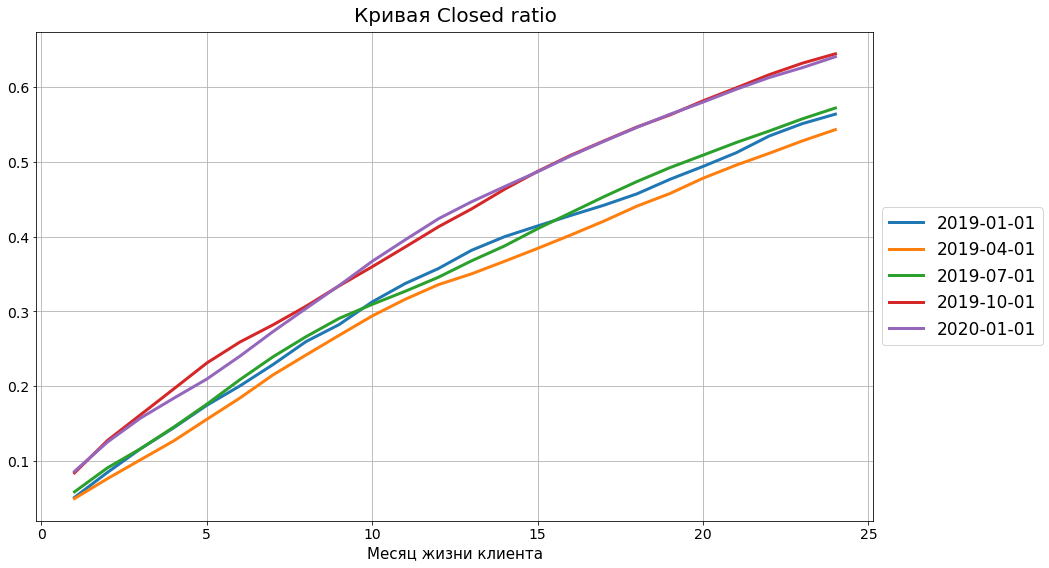

In [16]:
def plot_clo_ratio_by_generation(df):
#     код функции
    return (df.groupby(["gen_quarter_dt", "statement_num"])     # группировка по поколению и месяцу жизни клиента
    .agg({"clo_flg":np.mean})                                         # считаем средний уровень дефолта
    .rename(columns = {"clo_flg": 'clo_ratio'})                   # переименовываем столбец со средними значениями
    .unstack('gen_quarter_dt')['clo_ratio']
    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
           )
    
                                 # разворачиваем таблицу, столбцы теперь поколения
plot_clo_ratio_by_generation(df)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выбери переменную, которая делит кривые наилучшим образом (2 балла)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

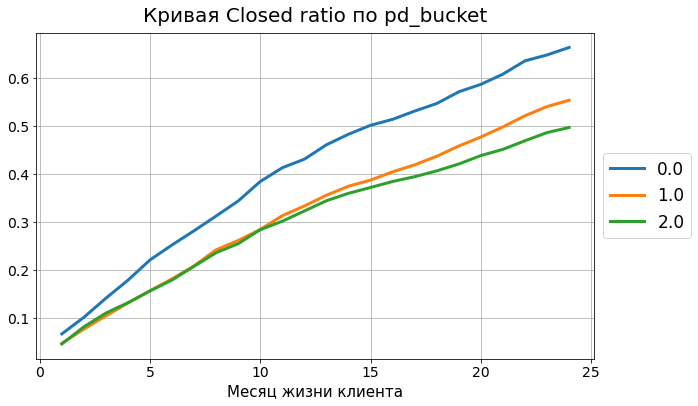

In [17]:
def plot_clo_ratio_by_bucket(df, bucket):
#     код функции
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
                .groupby([bucket, "statement_num"])
                .agg({"clo_flg":np.mean})
                .rename(columns = {"clo_flg": 'clo_ratio'})
                .unstack(bucket)
                ['clo_ratio']
                .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_clo_ratio_by_bucket(df, 'my_pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio по pd_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

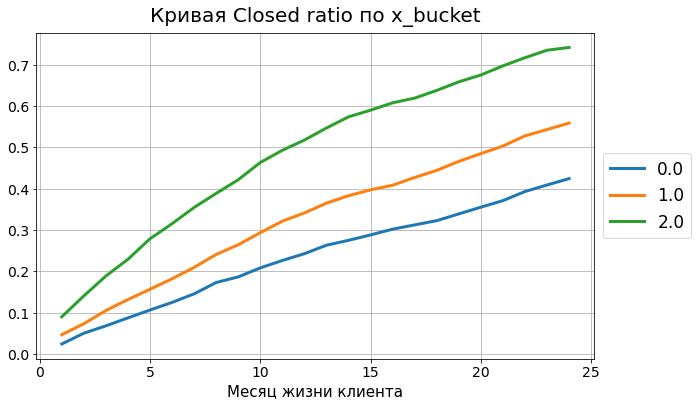

In [18]:
plot_clo_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed ratio по x_bucket", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: здесь укажи выбранную тобой переменную и обоснуй свой выбор

Кривые лучше разделены при делении выборки на бакеты по x_score - это подтверждено как визуально (на графиках), так и из среднего значения бакетов по x_score (средние идут почти линейно), в то время как средние pd-бакетов не однородны (1 и 2 почти не отличимы друг от друга по сравнению с 3-м) 

### Анализ странных поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

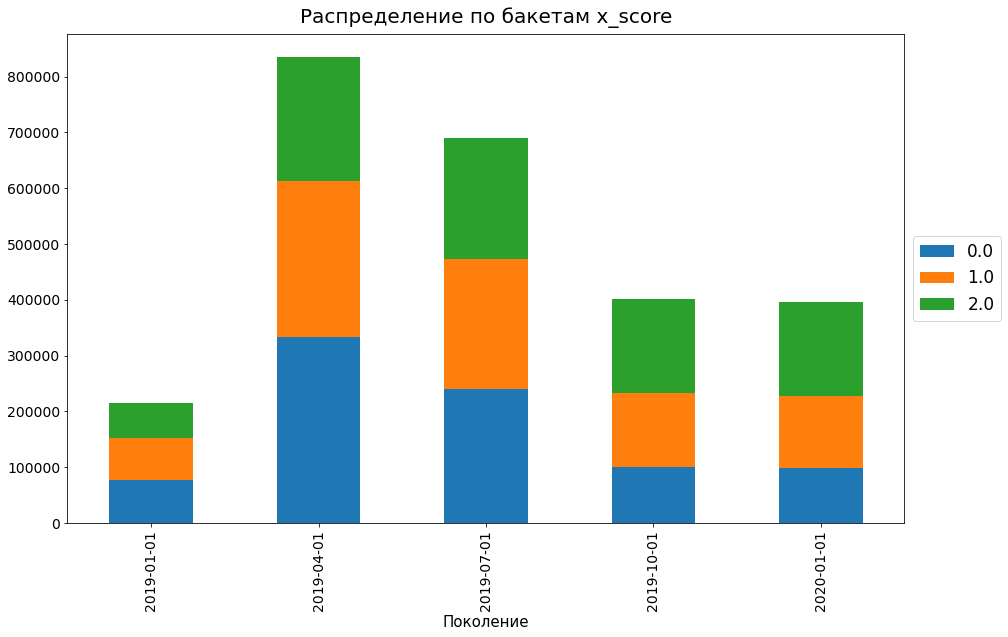

In [19]:
def plot_distribution(df, bucket):
#     код функции 
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам x_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

В январе 2019-года (начало первого квартал) данных мало, но достаточно для анализа, распределение по бакетам относительно равномерно, поэтому ничего не исключаем

### Кривые СLO Rate в разбивке по бакетам 

$CLO_n$ - количество счетов, закрывшихся в месяц $n$

$ACT_{n-1}$ - количество активных счетов (в просрочке 0-3) в месяц $n-1$

## $$ CLO Rate_n = \frac{\#CLO_n}{\#Act_{n-1}} $$

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

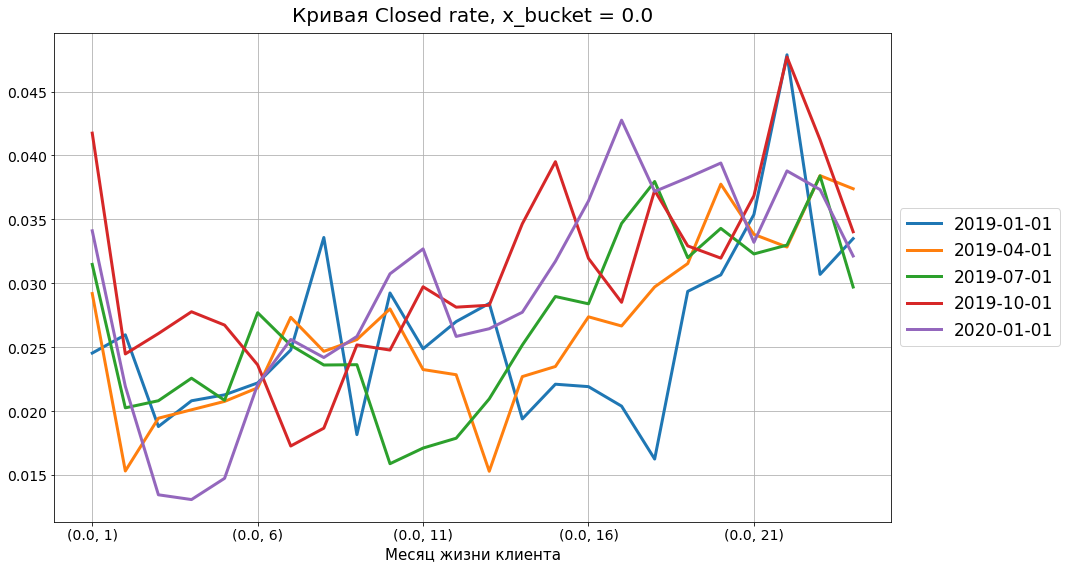

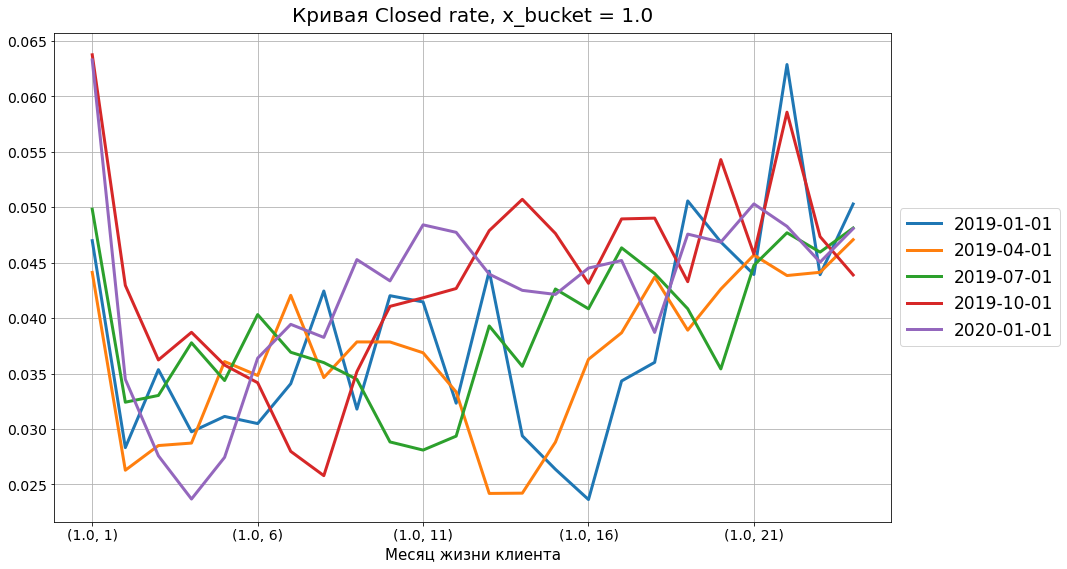

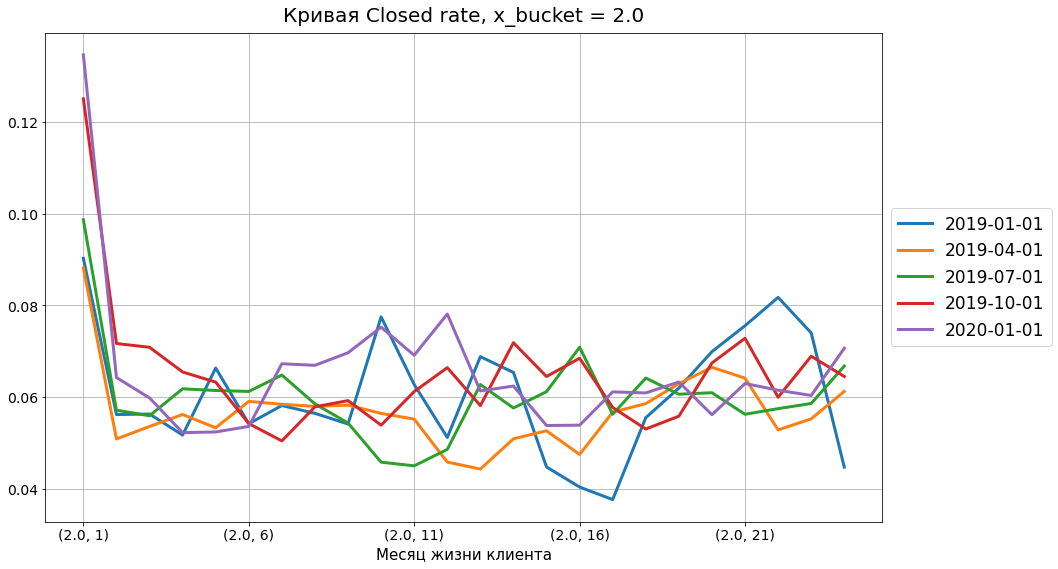

In [20]:
%matplotlib inline
# Выгружаем таблицу c винтажами

closed_rate_data = df.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_closed_rate_by_generation(x_bucket):
    
    cur_df = closed_rate_data.query('x_bucket == ' + str(x_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['clo_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Closed rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

for x_b in buckets:
    plot_closed_rate_by_generation(x_b)

#### Выводы: сделай выводы по полученным графикам
Первые два бакета имеют одновременный провал - в календарном смысле, а не относительно месяцев жизни клиента, то есть если их поставить на календарной временной прямой, то провал будет в одном месте - даже в таком виде видна периодичность между провалами. Более того, они на одном уровне.

В 2-м бакете всё неоднозначно - провалы кажутся цикличными, но идут на разном уровне - 01-2019 крайне шумно по сравнению с остальными поколениями - есть желание его удалить из бакета


### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

Особая точка присутствует в нуле - она объясняется повышенной вероятностью заранее закрыть кредит

### Среднее по бакетам (1 балл)
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

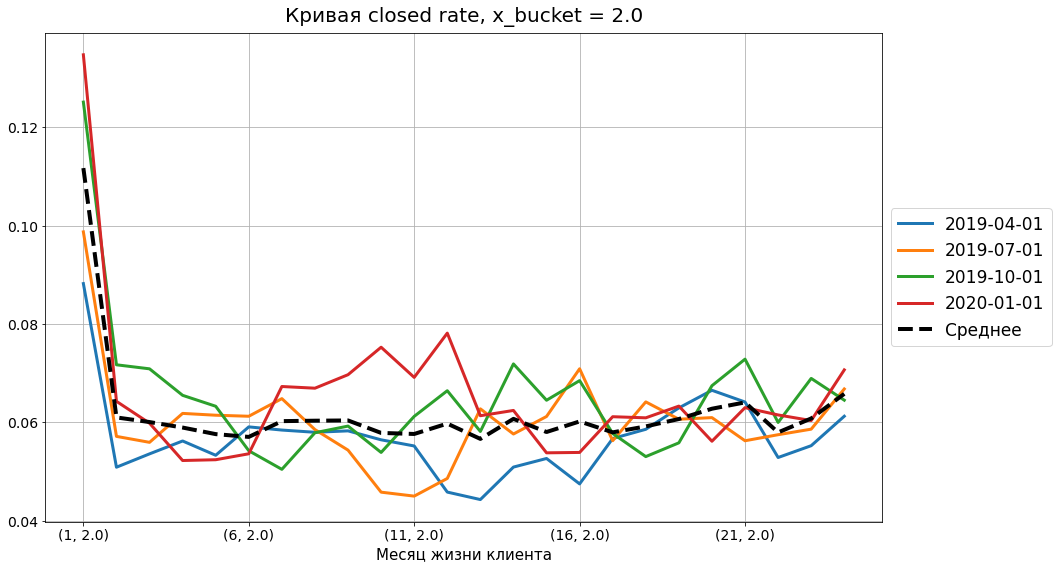

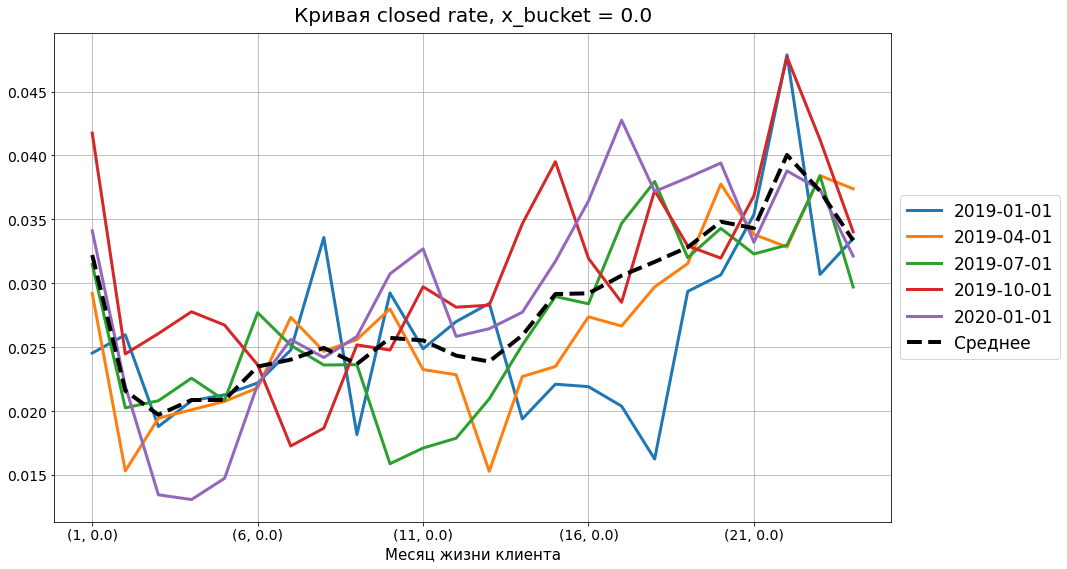

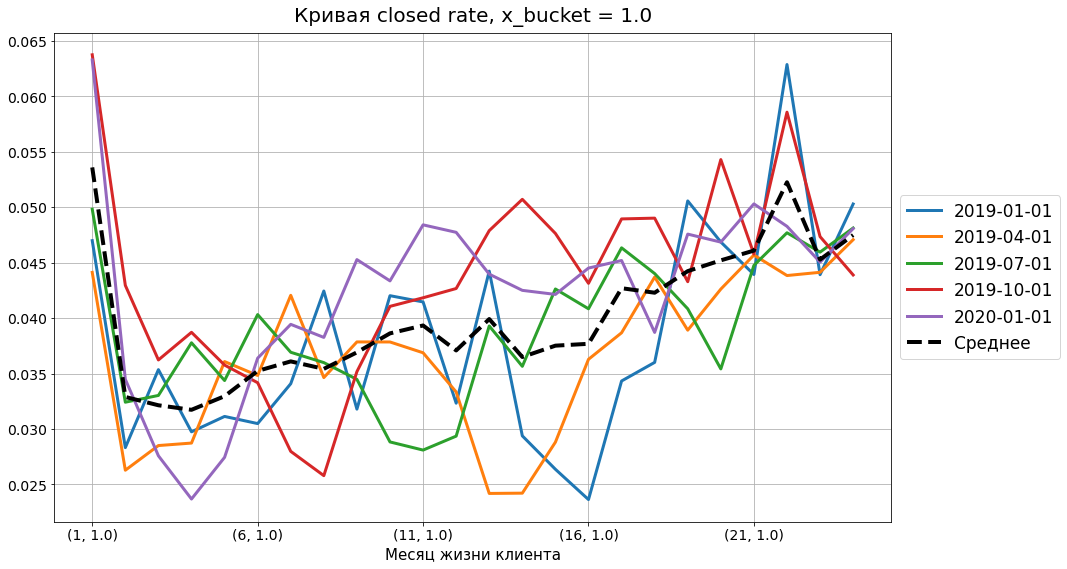

In [21]:


exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (x_bucket == 2)) '''
closed_rate_data.query(exception_query, inplace = True)

# Реализация расчета среднего
#     код здесь

closed_rate_mean = closed_rate_data.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':np.mean})\
    .rename(columns = {'clo_rate':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
#     код функции
    vintages_graph = closed_rate_data.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (closed_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая closed rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
for x_b in buckets:
    plot_clo_rate_mean(x_b)

### Сглаживание средних кривых (2 балла)

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

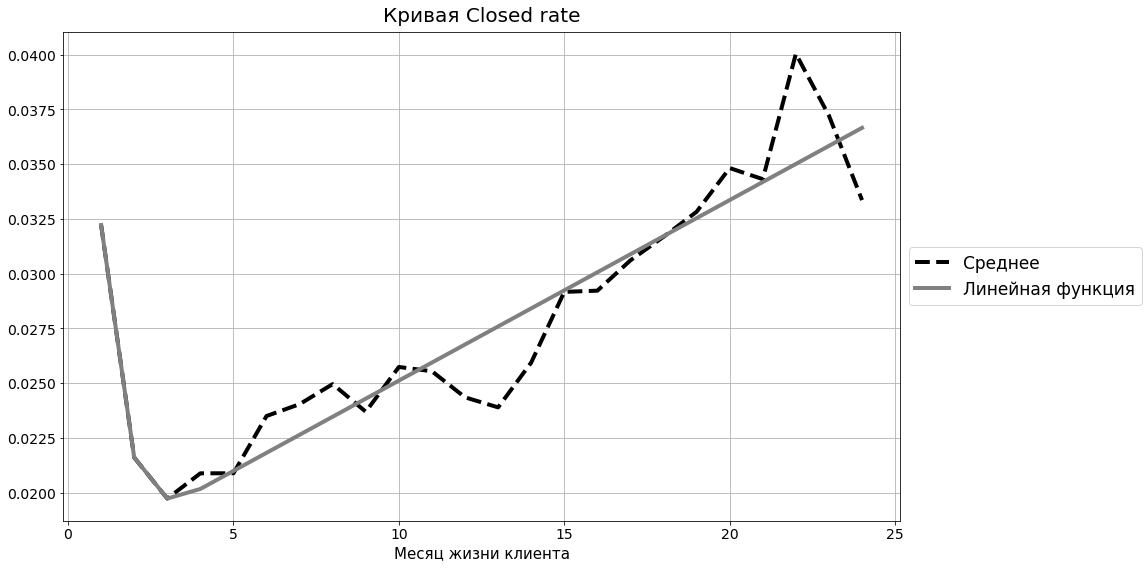

In [22]:
def approximation(df, start=1, finish=24):
#     код функции
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

df_linear = closed_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = approximation(df_linear, 4, 24)

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

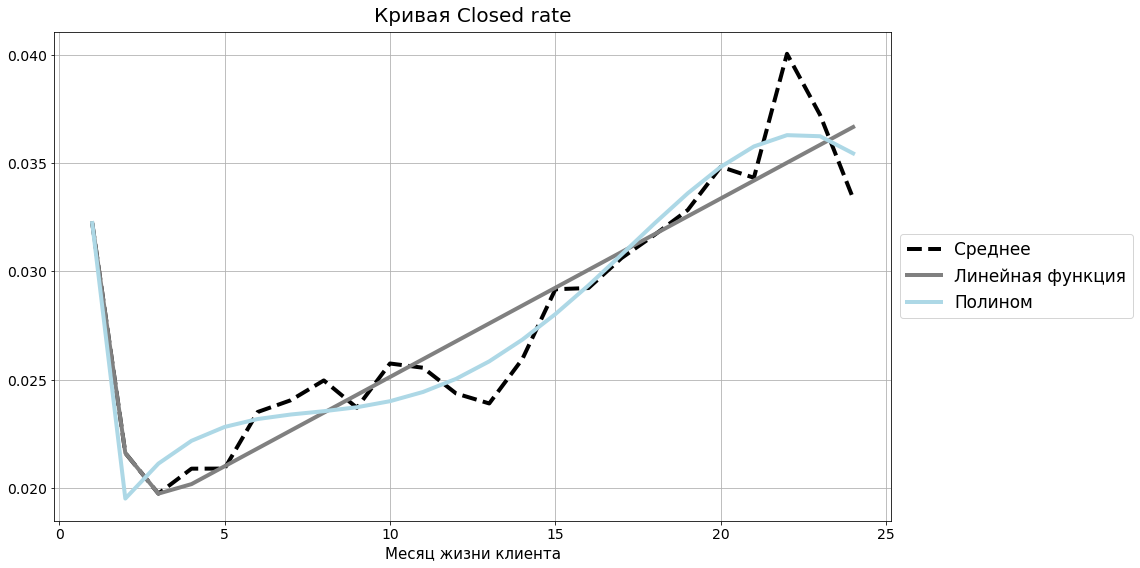

In [23]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 2,24,4)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Closed rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

Выбран полином 4-го порядка - на графике видно, что он смог с некоторой погрешностью повторить все ключевые события происходящие с графиком - спад в середине + пик в 22-23 месяце

### Отрисуй сглаженные кривые по всем трем бакетам PD

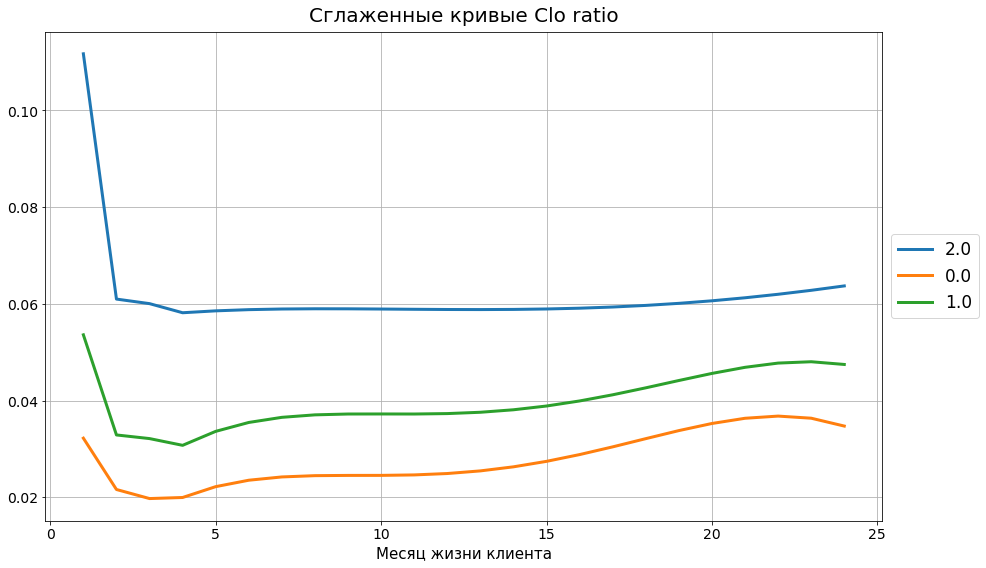

In [24]:
# код здесь
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = closed_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,24,4)['Полином']
    
# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [25]:
df_smooth_result.to_csv('clo_rate_by_buckets.csv')

## (Задача со звездочкой) 
## Макроэкономические воздействие (4 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание